SPDX-FileCopyrightText: Copyright (c) 2024 NVIDIA CORPORATION & AFFILIATES. All rights reserved.  
SPDX-License-Identifier: Apache-2.0

# NVDINOv2 NIM 워크샵

NVIDIA Inference Microservices(NIMs)는 AI 모델과 상호작용할 수 있는 사용하기 쉬운 API 기반 마이크로서비스 모음입니다.

이 워크샵은 범용 이미지 임베딩 모델인 NVDINOv2를 사용하는 방법에 중점을 둡니다. NVDINOv2는 분류 헤드나 KNN 알고리즘 및 벡터 데이터베이스와 결합하여 퓨샷(Few Shot) 분류 모델을 만들 수 있습니다. 이 접근 방식의 장점은 NVDINOv2가 이미 방대한 양의 데이터로 학습되어 다운스트림 작업에 사용할 수 있는 풍부한 특징의 임베딩을 생성할 수 있기 때문에 광범위한 모델 학습이나 상당한 컴퓨팅 리소스가 필요하지 않다는 것입니다.

NIM에 대해 자세히 알아보려면 <a href=https://build.nvidia.com/explore/discover> ai.nvidia.com </a>을 방문하세요.

![Few Shot Arch Diagram](readme_assets/few_shot_arch_diagram.png)

이 워크샵은 4개의 파트로 구성되어 있습니다:

**파트 0.** 환경 설정  
**파트 1.** NVDINOv2 요청   
**파트 2.** 데이터셋 준비  
**파트 3.** 퓨샷 분류

# 파트 0: 환경 설정

***다음 셀에 NIM API 키를 붙여넣으세요*** "nvapi-***" 형식으로 ```api_key``` 변수를 설정합니다. 그런 다음 셀을 계속 실행하여 종속성을 설치합니다. 이 노트북은 자동으로 6GB 크기의 공개 자동차 분류 데이터셋을 다운로드하며, 이는 노트북 전체에서 사용됩니다.

In [1]:
api_key = "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" #FIX ME 

In [2]:
# 종속성 설치
import sys 
python_exe = sys.executable
!{python_exe} -m pip install -r requirements.txt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
from datasets import load_dataset
from pymilvus import MilvusClient
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt 
from PIL import Image 
import requests 
import io 

from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CustomJS
from bokeh.layouts import column
from bokeh.io import output_notebook
from sklearn.manifold import TSNE
import numpy as np 
from bokeh.palettes import Dark2_5 as palette
import itertools

/Users/jipibe.j/jiwon-project/nvidia-work/GenerativeAIExamples/vision_workflows/metropolis-nim-workflows/nim_workflows/nvdinov2_few_shot/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


계속하기 전에 위의 두 셀에서 설치 및 가져오기 중에 오류가 발생하지 않았는지 확인하세요.

# 파트 1: NVDINOv2 요청

NVDINOv2로 이미지 임베딩을 생성하려면 먼저 NVCF 대용량 자산 API를 통해 이미지를 업로드한 다음 NVDINOv2 NIM API 호출을 해야 합니다.

NVDINOv2의 입력 해상도는 960x544입니다. 이 크기의 대부분의 이미지는 NVDINOv2 NIM API 호출에 직접 포함하기에는 너무 크므로 먼저 대용량 자산 API를 사용하여 이미지를 업로드합니다. 이미지가 업로드되면 NVDINOv2 요청에서 이미지를 참조하는 데 사용할 수 있는 고유 ID가 반환됩니다.

NVDINOv2 NIM API에 요청을 보내려면 인증을 위한 API 키가 포함된 헤더와 임베딩할 콘텐츠가 포함된 페이로드가 필요합니다.

헤더에서 API 키는 Bearer 토큰으로 제공되어야 하며 요청 본문은 JSON 형식입니다.

추가 참고자료:
* [NVDINOv2 NIM API 문서](https://docs.api.nvidia.com/nim/reference/nvidia-nv-dinov2-infer)
* [NVCF 대용량 자산 API 문서](https://docs.api.nvidia.com/cloud-functions/reference/createasset)

In [4]:
# URL 및 키
assets_url = "https://api.nvcf.nvidia.com/v2/nvcf/assets" # 대용량 자산 업로드
nvdinov2_url = "https://ai.api.nvidia.com/v1/cv/nvidia/nv-dinov2" # nvdinov2 엔드포인트
header_auth = f"Bearer {api_key}" # 헤더에 포함할 인증 정보

첫 번째 단계는 자산 ID를 생성하고 이미지 업로드 링크를 가져오는 것입니다.

In [5]:
# 1단계) 업로드 링크를 가져오기 위한 요청 보내기
headers = {
    "Authorization": header_auth,
    "Content-Type": "application/json",
    "accept": "application/json",
}
payload = {"contentType": f"image/jpeg", "description": "input image"}
response = requests.post(assets_url, headers=headers, json=payload, timeout=30)
response.raise_for_status()

# asset_url은 업로드 링크이고 asset_id는 이미지를 참조하는 고유 식별자입니다
asset_url = response.json()["uploadUrl"]
asset_id = response.json()["assetId"]

In [6]:
response.json()

{'assetId': 'a6cbbcd9-bfff-4015-97f4-6d3e144caf41',
 'uploadUrl': 'https://nv-gdn-strap-assets-prd.s3-accelerate.amazonaws.com/tJjLh4Tp8ddF0p3Pk60nXqSJqx-y9JE4M1a9O4ej4GM/a6cbbcd9-bfff-4015-97f4-6d3e144caf41?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEPf%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaDmFwLW5vcnRoZWFzdC0xIkYwRAIgE%2FdpQD1XQkhxWJp97OcaVmF9ReiPp9YZCGUxBCfJFcsCIFMd4Ag256lzQbnAN6WbijH44zQX8r8dNRKljnkSHzcuKrkFCLD%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEQAhoMMDUyMjc3NTI4MTIyIgyibMCFp%2FVF26TklaoqjQXRm0MLVtuTQg%2BG43GwZkCCEoQyy45UC6Yz8qaZSjZo9W8v6fUAM28dDAgJqM4L%2Fy0k8cxGNLjc0RCUJqtA9ogadOlOHuk8wR%2FjIMzNw40uDNjhME4bYVCWVkmIq5beZNRMv96uq3i6EZZdAaeW2oNJC9FPF%2Fwtq2ler8ys%2F9X3cuGD1EURyeFcPKsH5Y1Mz0lXZdK8MnSIsLNxlTC6K9p0QCppAzPJeewZGA9w9BsAU2ag0mfW3zcaVSivSGoacKffU%2FKC9zdyzCzxquv39Db2bF5OUeRHpXBsPOk3sRURdWy2b1pFM6rSe98d4VkQljY28KH84VMeHCxdIMuOm%2F2WOasfJhknOQIkShr4YSTkRViBp6WOebgUL0nLk6vx2%2BKMImcn4aF4SUbhkhJUWLWIoXDBPPknwGDpXv%2B%2FRpHPeA6kIhmm0CoNuSdnrA%2BNfmXhTkCYpR8lxTnw5dfHuSk%2FggMWuTIoVC53pkU9Ho4Avf1

이제 자산 ID와 이미지를 업로드할 AWS S3 링크를 얻었습니다.

In [7]:
# 2단계) asset_url에 이미지 업로드
s3_headers = {
    "x-amz-meta-nvcf-asset-description": "input image",
    "content-type": f"image/jpeg",
}
# 업로드하기 전에 이미지를 jpeg로 변환
image = Image.open("readme_assets/few_shot_arch_diagram.png").convert("RGB")
buf = io.BytesIO()  # 이미지를 저장할 임시 버퍼
image.save(buf, format="JPEG") # 더 작은 업로드 크기를 얻기 위해 이미지를 jpeg로 변환

# 이미지 업로드
response = requests.put(
    asset_url,
    data=buf.getvalue(),
    headers=s3_headers,
    timeout=300,
)
response.raise_for_status()

In [8]:
response

<Response [200]>

이미지가 업로드되었으며 이제 NIM API 요청에서 자산 ID를 사용하여 참조할 수 있습니다.

In [9]:
# 3단계) NVDINOv2 요청을 보내고 업로드된 이미지 참조
payload = {"messages": []} # 페이로드는 빈 "messages" 필드만 있으면 됩니다. 이미지가 헤더에서 참조되므로 페이로드에 다른 정보가 필요하지 않습니다.
asset_list = f"{asset_id}"

# 자산 ID는 헤더에 포함되어야 합니다
headers = {
    "Content-Type": "application/json",
    "NVCF-INPUT-ASSET-REFERENCES": asset_id,
    "NVCF-FUNCTION-ASSET-IDS": asset_id,
    "Authorization": header_auth,
}

# 임베딩을 생성하기 위해 NVDINOv2 요청 보내기
response = requests.post(nvdinov2_url, headers=headers, json=payload)
response = response.json()
#print(response)
embedding = response["metadata"][0]["embedding"] # 임베딩 가져오기

In [10]:
print(len(embedding))
print(type(embedding[0]))
# print(embedding) # 전체 임베딩 벡터를 출력하려면 주석 해제

1536
<class 'float'>


응답에서 이미지의 임베딩을 얻을 수 있습니다. 이것은 이미지를 나타내는 1536차원 벡터이며 분류와 같은 다운스트림 작업에 사용할 수 있습니다.

## 파트 2: 데이터셋 준비

NVDINOv2 임베딩을 퓨샷 분류에 사용하는 방법을 보여주기 위해 [HuggingFace의 자동차 분류 데이터셋](https://huggingface.co/datasets/tanganke/stanford_cars)을 사용할 수 있습니다. 다음 셀은 6GB 데이터셋을 다운로드합니다. 사용자가 선택한 각 데이터셋에 대해 사용자는 데이터셋 라이선스가 의도한 목적에 적합한지 확인할 책임이 있습니다.

In [11]:
dataset = load_dataset("tanganke/stanford_cars") # 6GB
train_set = dataset["train"]
test_set = dataset["test"]

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 8144
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 8041
    })
    contrast: Dataset({
        features: ['image', 'label'],
        num_rows: 8041
    })
    gaussian_noise: Dataset({
        features: ['image', 'label'],
        num_rows: 8041
    })
    impulse_noise: Dataset({
        features: ['image', 'label'],
        num_rows: 8041
    })
    jpeg_compression: Dataset({
        features: ['image', 'label'],
        num_rows: 8041
    })
    motion_blur: Dataset({
        features: ['image', 'label'],
        num_rows: 8041
    })
    pixelate: Dataset({
        features: ['image', 'label'],
        num_rows: 8041
    })
    spatter: Dataset({
        features: ['image', 'label'],
        num_rows: 8041
    })
})

1개의 이미지를 임베딩하는 데 1 NIM 크레딧이 소요되므로 퓨샷 분류 모델을 구축하는 방법을 보여주기 위해 훨씬 작은 데이터 하위 집합을 생성합니다. 하위 집합은 3개의 클래스를 갖게 됩니다. 각 클래스는 10개의 테스트 이미지와 5개의 학습 이미지를 갖게 됩니다. 아래 셀을 조정하여 하위 집합의 데이터를 제어할 수 있습니다.

In [15]:
# 5개의 학습 이미지와 10개의 테스트 이미지를 가진 3개 클래스
num_classes = 4
test_images_per_class = 10
train_images_per_class = 5

In [16]:
range(1,num_classes)

range(1, 4)

In [17]:
def make_subset(dataset, classes, images_per_class):
    """주어진 클래스 목록과 지정된 클래스당 이미지 수로 하위 집합 만들기"""
    subset = []
    label_counter = {}
    for i, sample in enumerate(dataset):
        label = sample["label"]
        if label not in classes:
            continue 
            
        label_count = label_counter.get(label, 0)
    
        if label_count < images_per_class:
            subset.append(sample)
            label_counter[label] = label_counter.get(label, 0) + 1
    return subset

In [18]:
# 학습 및 테스트를 위한 하위 집합 만들기
train_subset = make_subset(dataset["train"], range(1,num_classes), train_images_per_class)
test_subset = make_subset(dataset["train"], range(1,num_classes), test_images_per_class)
print(len(train_subset))
print(len(test_subset))

15
30


임베딩 생성을 쉽게 하기 위해 이 노트북과 같은 디렉토리의 nvdinov2.py 스크립트에 NVDINOv2 래퍼 클래스가 구현되어 있습니다. 이것은 이미지 업로드 및 임베딩 호출을 처리합니다. 이미지 경로 목록 또는 PIL 이미지를 전달할 수 있습니다. 각 이미지에 대한 임베딩 목록을 반환합니다.

In [25]:
from nvdinov2 import NVDINOv2
def add_embeddings(api_key, dataset):
    nvdinov2 = NVDINOv2(api_key)
    for i, sample in enumerate(dataset):
        print(sample)
    pil_images = [x["image"] for x in dataset] # 데이터셋에서 PIL 이미지 가져오기
    embeddings = nvdinov2(pil_images) # nvdinov2에 이미지 목록 전달
    for i in range(len(dataset)):
        dataset[i]["embedding"] = embeddings[i]
    return dataset

NVCLIP은 퓨샷 분류에도 사용할 수 있는 NIM으로 제공되는 또 다른 임베딩 모델입니다. NVDINOv2와 비교하여 어떻게 작동하는지 보려면 아래 셀의 주석을 해제하여 NVDINOv2의 임베딩을 NVCLIP의 임베딩으로 교체하고 노트북의 나머지 부분을 실행하세요. NVCLIP을 사용하려면 섹션 3.2에서 임베딩 차원을 1536에서 1024로 변경해야 합니다.

In [34]:
# from nvclip import NVCLIP
# def add_embeddings(api_key, dataset):
#     nvclip = NVCLIP(api_key)
#     pil_images = [x["image"] for x in dataset]
#     print(len(pil_images))
#     embeddings = nvclip(pil_images)
#     print(embeddings)
#     print(len(embeddings))
#     for i in range(len(dataset)):
#         dataset[i]["embedding"] = embeddings[i]
#     return dataset

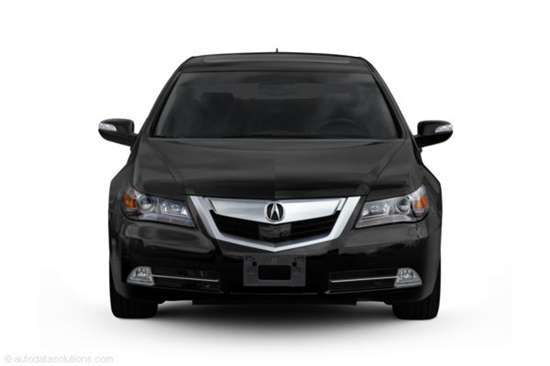

In [26]:
pil_images = [x["image"] for x in train_subset]

pil_images[0]

In [27]:
# 테스트 및 학습 데이터셋에 임베딩 추가
train_subset = add_embeddings(api_key, train_subset)


{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=550x366 at 0x17AA8E3F0>, 'label': 1, 'embedding': [1.08203125, 0.99755859375, 1.6640625, 1.177734375, 1.6123046875, 1.6015625, -0.1748046875, -0.486083984375, -0.53076171875, 1.2275390625, -2.400390625, 0.26513671875, 0.26220703125, -0.89599609375, -0.243408203125, -1.181640625, -0.7724609375, -1.7431640625, 1.8212890625, -0.027679443359375, 0.5107421875, -1.48046875, -0.24853515625, 3.384765625, -0.1905517578125, 0.164794921875, 0.8427734375, 2.83984375, 2.333984375, 0.64697265625, -0.6298828125, 1.6708984375, -1.37109375, -0.60595703125, -1.0224609375, 0.432373046875, 1.0205078125, 0.298828125, -0.0197296142578125, -0.83154296875, 2.09765625, 0.19580078125, -0.57958984375, -0.53564453125, -0.314453125, 0.01495361328125, 1.0517578125, -1.6591796875, -1.865234375, -1.001953125, -1.8095703125, 0.80419921875, 0.7705078125, -0.73046875, 0.08074951171875, -0.208251953125, 0.8115234375, -0.77294921875, 0.280029296875, -0.85986

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 1936.73it/s]


collecting responses


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:07<00:00,  1.98it/s]


In [ ]:
test_subset = add_embeddings(api_key, test_subset)

In [22]:
test_subset

[{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=550x366>,
  'label': 1,
  'embedding': [-0.327880859375,
   -0.3017578125,
   1.2734375,
   -1.2587890625,
   1.37109375,
   -0.318603515625,
   -0.65478515625,
   -0.09674072265625,
   -0.0081787109375,
   1.0302734375,
   -2.158203125,
   0.197998046875,
   0.45361328125,
   0.425048828125,
   0.385986328125,
   0.428466796875,
   0.98486328125,
   -1.1083984375,
   2.044921875,
   0.61572265625,
   0.951171875,
   0.40087890625,
   0.80517578125,
   2.482421875,
   -0.365234375,
   1.4501953125,
   1.638671875,
   0.4267578125,
   -0.323974609375,
   1.0986328125,
   -1.2744140625,
   0.08697509765625,
   0.066162109375,
   0.537109375,
   -0.4775390625,
   -1.0048828125,
   1.216796875,
   -1.2373046875,
   -1.732421875,
   -0.41455078125,
   2.814453125,
   0.79248046875,
   -0.1976318359375,
   -1.0078125,
   2.67578125,
   -0.1688232421875,
   1.7294921875,
   -2.455078125,
   -1.4189453125,
   -0.18701171875,
   

다음 셀은 테스트 데이터를 2차원으로 플롯하여 시각적으로 검사할 수 있도록 합니다.

In [29]:
# Jupyter 노트북에서 Bokeh 출력 활성화
output_notebook()
vectors = np.array([x["embedding"] for x in test_subset])
class_labels =  np.array([x["label"] for x in test_subset])


# TSNE를 사용하여 임베딩을 2D로 투영
tsne = TSNE(
    n_components=2,
    perplexity=5,
    learning_rate=200,
    early_exaggeration=5,
    # n_iter=2000,
    random_state=42,
    metric="cosine",
)
embedding_2d = tsne.fit_transform(vectors)

p = figure(
    title="Embedding Visualization",
    tools="pan,wheel_zoom,box_zoom,reset,hover,save",
)
colors = itertools.cycle(palette)

# 각 클래스 플롯
for n in np.unique(class_labels):
    indices = np.where(class_labels == n)
    n_vectors = embedding_2d[indices]
    x = n_vectors[:, 0]
    y = n_vectors[:, 1]

    source = ColumnDataSource(dict(x=x, y=y))

    p.scatter("x", "y", source=source, size=8, color=next(colors), legend_label=str(n))

# 레이아웃
layout = column(p)
# 노트북에 플롯 표시
show(layout)


Loading BokehJS ...

이제 이미지 임베딩이 생성되었으므로 SKLearn의 모델을 사용하거나 KNN 알고리즘과 Milvus 벡터 데이터베이스를 사용하여 퓨샷 분류를 구현할 수 있습니다. 두 가지 방법 모두 다음 섹션에서 살펴보겠습니다.

# 파트 3: 퓨샷 분류

이 단계에서 테스트 및 학습 데이터셋의 각 이미지에는 NVDINOv2 또는 NVCLIP에서 생성한 관련 이미지 임베딩이 있습니다. 이러한 이미지 임베딩은 이미지의 내용을 이해하는 데 필요한 가장 중요한 정보를 포함하는 이미지의 압축된 버전입니다. 이러한 임베딩의 속성은 서로 유사한 이미지가 임베딩 공간에서 서로 가까이 있다는 것입니다. 파트 2의 플롯에서 동일한 클래스의 이미지가 서로 가까이 나타나고 클러스터를 형성해야 합니다. 이러한 임베딩(특징 벡터라고도 함)에는 서로 다른 클래스의 이미지를 구별하기에 충분한 정보가 포함되어 있기 때문에 로지스틱 회귀 또는 KNN 알고리즘과 같은 간단한 분류 모델의 입력으로 사용할 수 있습니다.

## 파트 3.1 SKLearn

SKLearn은 이미지 임베딩과 함께 사용할 수 있는 여러 분류 모델을 제공합니다. 각 분류 모델은 학습하기 위해 특징 집합과 레이블이 필요합니다. 이 경우 임베딩이 특징이고 클래스 ID가 레이블입니다.

이제 임베딩을 [로지스틱 회귀](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) 및 [K 최근접 이웃](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)과 같은 SKLearn의 경량 분류 헤드와 결합할 수 있습니다. 강력한 임베딩 모델을 사용하면 매우 적은 수의 이미지로 높은 정확도를 달성할 수 있다는 이점이 있습니다. 이렇게 하면 분류 모델을 생성하는 데 필요한 계산량이 크게 줄어들고 GPU 없이도 수행할 수 있습니다.

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# 레이블과 특징으로 분할
x_test = [x["embedding"] for x in test_subset]
y_test = [x["label"] for x in test_subset]

x_train = [x["embedding"] for x in train_subset]
y_train = [x["label"] for x in train_subset]

다음 두 셀은 데이터셋에서 로지스틱 회귀 및 KNN 분류 모델을 학습하고 테스트합니다.

In [31]:
# 로지스틱 회귀 헤드 피팅 및 테스트
model = LogisticRegression()
model.fit(x_train, y_train)
y_predict = model.predict(x_test)
report = classification_report(y_test, y_predict)
print(report)

              precision    recall  f1-score   support

           1       0.78      0.70      0.74        10
           2       0.55      0.60      0.57        10
           3       0.70      0.70      0.70        10

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30



In [32]:
# KNN 분류 헤드 피팅 및 테스트
model = KNeighborsClassifier(n_neighbors=3, weights="distance")
model.fit(x_train, y_train)
y_predict = model.predict(x_test)
report = classification_report(y_test, y_predict)
print(report)

              precision    recall  f1-score   support

           1       0.88      0.70      0.78        10
           2       0.45      0.50      0.48        10
           3       0.64      0.70      0.67        10

    accuracy                           0.63        30
   macro avg       0.66      0.63      0.64        30
weighted avg       0.66      0.63      0.64        30



분류 리포트에서 볼 수 있듯이 모델은 클래스당 5개의 학습 이미지만으로 90% 정확도를 얻을 수 있으며 퓨샷 분류 모델을 생성하는 데 매우 적은 컴퓨팅 리소스가 필요했습니다.

## 파트 3.2 Milvus 벡터 데이터베이스

K-최근접 이웃(KNN) 분류 알고리즘을 사용하는 한 가지 장점은 벡터 데이터베이스로 효율적으로 확장하고 구현할 수 있다는 것입니다. 벡터 데이터베이스는 새로운 이미지 임베딩을 빠르게 삽입할 수 있고 빠른 유사도 검색을 허용합니다. 우리는 이미 동일한 클래스에 속하는 이미지가 임베딩 공간에서 서로 가까이 있는 경향이 있다는 것을 논의했습니다. 학습 세트의 이미지 임베딩을 벡터 데이터베이스에 저장하면 가장 유사한 임베딩(최근접 이웃)과 관련 레이블을 검색하여 새 이미지를 분류할 수 있습니다. 그런 다음 이러한 최근접 이웃 중 가장 일반적인 레이블이 새 이미지의 레이블로 예측됩니다. 이것이 [K-최근접 이웃](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) 알고리즘이 작동하는 기본 원리입니다.

Milvus를 사용하여 'add' 및 'predict' 메서드로 KNN 분류기가 구현됩니다. 이를 통해 필요에 따라 새로운 예제와 클래스를 데이터베이스에 삽입할 수 있으며 예측은 항상 데이터베이스의 최신 샘플을 고려합니다.

Milvus에 대해 자세히 알아보려면 [문서 페이지](https://milvus.io/docs)를 방문하세요.

In [37]:
from collections import Counter
from pathlib import Path
class KNeighborsClassifierMilvus:
    def __init__(self, database="milvus_demo.db", collection="knn", rm=True, embedding_d=1536):
        
        self.database = database
        self.collection = collection
        self.id_tracker = 0 # 새 데이터를 삽입하기 위해 ID 추적

        # 로컬 데이터베이스가 존재하면 삭제
        if rm:
            Path.unlink(self.database, missing_ok=True)

        # 데이터베이스에 연결
        self.client = MilvusClient(self.database)
       
        # 컬렉션 설정
        if not self.client.has_collection(collection_name=self.collection):
            # 데이터베이스에 컬렉션 생성. 이렇게 하면 벡터가 메타데이터와 연결됩니다
            self.client.create_collection(
                collection_name=self.collection,
                dimension=embedding_d, # NVDINOv2의 경우 1536, NVCLIP의 경우 1024
                metric_type="L2"
                )
        
    def add(self, x, y):
        """레이블이 지정된 임베딩을 분류기에 추가"""
        milvus_samples = []
        for i, vector in enumerate(x):
            sample = {"id":self.id_tracker, "vector":vector, "label":y[i]}
            self.id_tracker += 1
            milvus_samples.append(sample)
        self.client.insert(collection_name=self.collection, data=milvus_samples)
    def predict(self, x, n_neighbors=1):
        """2차원 벡터 리스트 전달"""
        labels = []
        results = self.client.search(collection_name=self.collection, data=x, limit=n_neighbors, output_fields=["label"])
        for result in results:
            neighbor_labels = [x["entity"]["label"] for x in result]
            label_counter = Counter(neighbor_labels)
            label = label_counter.most_common()[0][0] # 이웃에서 가장 일반적인 레이블 가져오기
            labels.append(label)
        return labels 

이제 이것을 실행하고 SKLearn 모델과 결과를 비교할 수 있습니다. 정확도는 비슷해야 합니다.

In [39]:
model = KNeighborsClassifierMilvus(embedding_d=1536) # NVCLIP 임베딩을 사용하는 경우 embedding_d=1024 전달
model.add(x_train, y_train)
y_predict = model.predict(x_test, n_neighbors=2)
report = classification_report(y_test, y_predict)
print(report)

/Users/jipibe.j/jiwon-project/nvidia-work/GenerativeAIExamples/vision_workflows/metropolis-nim-workflows/nim_workflows/nvdinov2_few_shot/venv/lib/python3.13/site-packages/milvus_lite/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


              precision    recall  f1-score   support

           1       0.78      0.70      0.74        10
           2       0.56      0.50      0.53        10
           3       0.58      0.70      0.64        10

    accuracy                           0.63        30
   macro avg       0.64      0.63      0.63        30
weighted avg       0.64      0.63      0.63        30



## 파트 3.3 퓨샷 분류를 위한 대화형 Gradio UI

이 모든 것을 통합하여 퓨샷 분류를 빠르게 실험할 수 있는 Gradio UI를 구축할 수 있습니다. UI를 사용하면 원하는 수의 클래스를 추가하고 샘플 이미지를 업로드하고 새 이미지에서 추론할 수 있습니다. NVDINOv2 또는 NVCLIP을 사용하도록 실행할 수 있습니다. Gradio UI를 종료하려면 셀을 수동으로 중지해야 합니다.

In [40]:
!{python_exe} main.py {api_key} nvdinov2

/Users/jipibe.j/jiwon-project/nvidia-work/GenerativeAIExamples/vision_workflows/metropolis-nim-workflows/nim_workflows/nvdinov2_few_shot/venv/lib/python3.13/site-packages/milvus_lite/__init__.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
^C
Keyboard interruption in main thread... closing server.


In [ ]:
!{python_exe} main.py {api_key} nvclip